In [1]:
from alfalfa import AlfalfaTree, AlfalfaForest
from alfalfa.tree_models.tree_kernels import AlfalfaGP
from alfalfa.tree_models.forest import DecisionNode
from alfalfa.fitting.bart.bart import BART
from alfalfa.fitting.bart.data import Data
from alfalfa.leaf_gp.space import Space, Dimension
from alfalfa.fitting.bart.params import BARTTrainParams
from alfalfa.utils.plots import plot_gp_1d, plot_covar_matrix

import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt
import scipy.stats as stats

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
# data
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 10).reshape(-1, 1)
space = Space([[0.0, 1.0]])

# True function is sin(2*pi*x) with Gaussian noise
torch.manual_seed(42)
np.random.seed(42)
f = lambda x: torch.sin(x * (2 * math.pi))
train_y = (f(train_x) + torch.randn(train_x.size()) * 0.2).flatten()
data = Data(space, train_x)


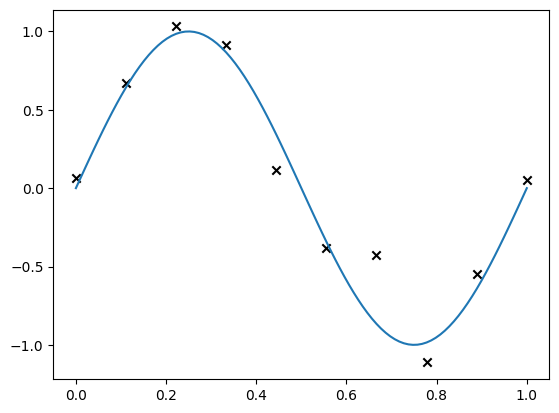

In [3]:
test_x = torch.linspace(0, 1, 100)
plt.scatter(train_x, train_y, color="black", marker="x")
plt.plot(test_x, f(test_x))

In [179]:
# model
# tree = AlfalfaTree(height=0)
# tree.initialise(space, data.get_init_prior())
forest = AlfalfaForest(height=0, num_trees=5)
forest.initialise(space)
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())
model = AlfalfaGP(train_x, train_y, likelihood, forest)

In [180]:
# bart setup
params = BARTTrainParams(warmup_steps=300, n_steps=50, lag=5)
bart = BART(model, data, params, 
            scale_prior=stats.halfnorm(scale=10.0),
            noise_prior=stats.halfnorm(scale=10.0))

In [181]:
# run the warmup
bart.run()

100%|██████████| 50/50 [00:02<00:00, 20.20it/s]


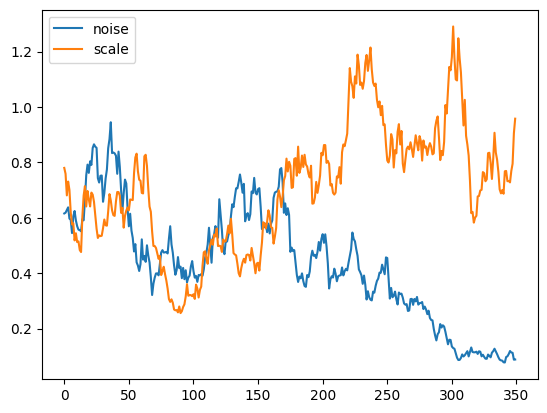

In [182]:
plt.plot(bart.logger["noise"], label="noise")
plt.plot(bart.logger["scale"], label="scale")
plt.legend()

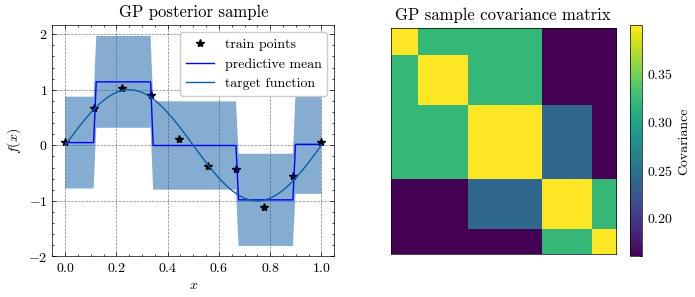

In [232]:
import scienceplots
plt.style.use(["science", "no-latex", "grid"])
model.eval()
test_x = torch.linspace(0, 1, 100).reshape(-1, 1)
fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
model.covar_module.outputscale = 0.4
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$f(x)$")
axs[0].set_title("GP posterior sample")
axs[1].set_title("GP sample covariance matrix")
plot_gp_1d(model, test_x, f, axs[0])
_, im = plot_covar_matrix(model, test_x, axs[1])
fig.colorbar(im, label="Covariance")
fig.savefig(r"../../figs/model_fit.pdf")

In [220]:
model.covar_module.outputscale

tensor(0.5368, grad_fn=<SoftplusBackward0>)

c:\Users\tobyb\phd\phdvenv\lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


[]

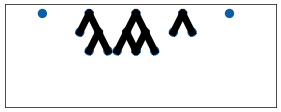

In [225]:
import alfalfa.utils.plot_trees as plottrees
with torch.no_grad():
    bart.step()
fig, ax = plt.subplots()

plottrees.plot_forest(forest, ax)
ax.set_aspect("equal")
ax.set_xlim((-4, 25))
ax.set_ylim((-10, 1))
ax.set_xticks([])
ax.set_yticks([])